In [1]:
# =============================================================================
#                              IMPORTS
# =============================================================================
from __future__ import print_function  
import warnings
warnings.filterwarnings("ignore")    

import requests
import xml.etree.ElementTree as ET
import glob
import collections
collections.Iterable = collections.abc.Iterable

import numpy as np
import xarray as xr
import cftime
from eofs.xarray import Eof

import matplotlib.pyplot as plt
from matplotlib import colors as c
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import cartopy as cart
from cartopy.util import add_cyclic_point
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nc_time_axis
import seaborn as sn

In [2]:
import sys
sys.path.append("..")

In [3]:
from scripts.eof_utilities import calculate_anomaly, eofcalc_pcnorm, proj_onto_eof, EucDistance
from scripts.plot_utils import plot_explained_variance, contour_plot, plot_eofs_over_time, plot_map_with_threshold

In [4]:
from scripts.taylor_diagram_function import TaylorDiagram, corrcoef, create_taylor_diagram

#                           LOAD DATA

In [5]:
#------------ US bounding box in lat/lon (degrees)
us_lat_bounds = (24.031414, 49.47644)
us_lon_bounds = (233.75, 293.75)
figure = "/glade/work/ksilwimba/SPMIP_Project/spmip_code/ncar_system/spmip-eof-analysis/figures"
#------------ Data directory
path = "/glade/work/ksilwimba/SPMIP_Project/spmip_data/SPMIP_Data"

# -- CLM5 Experiments: sum layers 0 to 8 --
data_CLM5_Exp1  = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp1_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")
data_CLM5_Exp2  = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp2_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")
data_CLM5_Exp3  = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp3_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")
data_CLM5_Exp4a = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp4a_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")
data_CLM5_Exp4b = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp4b_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")
data_CLM5_Exp4c = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp4c_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")
data_CLM5_Exp4d = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp4d_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")

# -- ERA5 Land data (daily) --
ERA5_land = (
    xr.open_dataset("/glade/work/ksilwimba/SPMIP_Project/spmip_data/ERA5_Data/ERA5_Land.nc")
      .resample(time="1D")
      .mean()
)

# -- Create a mask (1 where data is valid, NaN elsewhere) --
sm = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp1_1980-2010.nc").mrlsl
mask = sm[0, 0, :, :] / sm[0, 0, :, :]  # 1 or NaN

#  CALCULATE ANOMALIES & AGGREGATIONS

In [6]:
#------------ Compute daily anomalies for each CLM5 experiment
annom_data_CLM5_Exp1 = data_CLM5_Exp1.map_blocks(calculate_anomaly, template=data_CLM5_Exp1).compute()
annom_data_CLM5_Exp2 = data_CLM5_Exp2.map_blocks(calculate_anomaly, template=data_CLM5_Exp2).compute()
annom_data_CLM5_Exp3 = data_CLM5_Exp3.map_blocks(calculate_anomaly, template=data_CLM5_Exp3).compute()
annom_data_CLM5_Exp4a = data_CLM5_Exp4a.map_blocks(calculate_anomaly, template=data_CLM5_Exp4a).compute()
annom_data_CLM5_Exp4b = data_CLM5_Exp4b.map_blocks(calculate_anomaly, template=data_CLM5_Exp4b).compute()
annom_data_CLM5_Exp4c = data_CLM5_Exp4c.map_blocks(calculate_anomaly, template=data_CLM5_Exp4c).compute()
annom_data_CLM5_Exp4d = data_CLM5_Exp4d.map_blocks(calculate_anomaly, template=data_CLM5_Exp4d).compute()
annom_era5_land = ERA5_land.map_blocks(calculate_anomaly, template=ERA5_land).compute()

#------------ Seasonal means of daily anomalies
data_CLM5_Exp1_seas = annom_data_CLM5_Exp1.groupby("time.season").mean("time") * mask
data_CLM5_Exp2_seas = annom_data_CLM5_Exp2.groupby("time.season").mean("time") * mask
data_CLM5_Exp3_seas = annom_data_CLM5_Exp3.groupby("time.season").mean("time") * mask
data_CLM5_Exp4a_seas = annom_data_CLM5_Exp4a.groupby("time.season").mean("time") * mask
data_CLM5_Exp4b_seas = annom_data_CLM5_Exp4b.groupby("time.season").mean("time") * mask
data_CLM5_Exp4c_seas = annom_data_CLM5_Exp4c.groupby("time.season").mean("time") * mask
data_CLM5_Exp4d_seas = annom_data_CLM5_Exp4d.groupby("time.season").mean("time") * mask

#------------ Monthly means of daily anomalies
data_CLM5_Exp1_month = annom_data_CLM5_Exp1.groupby("time.month").mean("time") * mask
data_CLM5_Exp2_month = annom_data_CLM5_Exp2.groupby("time.month").mean("time") * mask
data_CLM5_Exp3_month = annom_data_CLM5_Exp3.groupby("time.month").mean("time") * mask
data_CLM5_Exp4a_month = annom_data_CLM5_Exp4a.groupby("time.month").mean("time") * mask
data_CLM5_Exp4b_month = annom_data_CLM5_Exp4b.groupby("time.month").mean("time") * mask
data_CLM5_Exp4c_month = annom_data_CLM5_Exp4c.groupby("time.month").mean("time") * mask
data_CLM5_Exp4d_month = annom_data_CLM5_Exp4d.groupby("time.month").mean("time") * mask

#                    EOF ANALYSIS

In [7]:
# -- EOFs for CLM5 Exp1 --
spmip_pcs1, spmip_eofs1, spmip_eofs_corr1, spmip_var_fracs1, spmip_reconstruction1 = eofcalc_pcnorm(
    annom_data_CLM5_Exp1.drop("dayofyear"),
    w='sqrtcoslat',
    neofs=30,
    timeaxis='time',
    lonneg=None,
    latneg=None
)

# -- EOFs for CLM5 Exp2 --
spmip_pcs2, spmip_eofs2, spmip_eofs_corr2, spmip_var_fracs2, spmip_reconstruction2 = eofcalc_pcnorm(
    annom_data_CLM5_Exp2.drop("dayofyear"),
    w='sqrtcoslat',
    neofs=30,
    timeaxis='time',
    lonneg=None,
    latneg=None
)

# -- EOFs for CLM5 Exp3 --
spmip_pcs3, spmip_eofs3, spmip_eofs_corr3, spmip_var_fracs3, spmip_reconstruction3 = eofcalc_pcnorm(
    annom_data_CLM5_Exp3.drop("dayofyear"),
    w='sqrtcoslat',
    neofs=30,
    timeaxis='time',
    lonneg=None,
    latneg=None
)

# -- EOFs for CLM5 Exp4a --
spmip_pcs4a, spmip_eofs4a, spmip_eofs_corr4a, spmip_var_fracs4a, spmip_reconstruction4a = eofcalc_pcnorm(
    annom_data_CLM5_Exp4a.drop("dayofyear"),
    w='sqrtcoslat',
    neofs=30,
    timeaxis='time',
    lonneg=None,
    latneg=None
)

# -- EOFs for CLM5 Exp4b --
spmip_pcs4b, spmip_eofs4b, spmip_eofs_corr4b, spmip_var_fracs4b, spmip_reconstruction4b = eofcalc_pcnorm(
    annom_data_CLM5_Exp4b.drop("dayofyear"),
    w='sqrtcoslat',
    neofs=30,
    timeaxis='time',
    lonneg=None,
    latneg=None
)

# -- EOFs for CLM5 Exp4c --
spmip_pcs4c, spmip_eofs4c, spmip_eofs_corr4c, spmip_var_fracs4c, spmip_reconstruction4c = eofcalc_pcnorm(
    annom_data_CLM5_Exp4c.drop("dayofyear"),
    w='sqrtcoslat',
    neofs=30,
    timeaxis='time',
    lonneg=None,
    latneg=None
)

# -- EOFs for CLM5 Exp4d --
spmip_pcs4d, spmip_eofs4d, spmip_eofs_corr4d, spmip_var_fracs4d, spmip_reconstruction4d = eofcalc_pcnorm(
    annom_data_CLM5_Exp4d.drop("dayofyear"),
    w='sqrtcoslat',
    neofs=30,
    timeaxis='time',
    lonneg=None,
    latneg=None
)

# -- EOFs for ERA5-Land --
annom_era5_land = annom_era5_land.__xarray_dataarray_variable__
era5_pcs, era5_eofs,  era5_eofs_corr, era5_var_fracs, era5_reconstruction = eofcalc_pcnorm(
   annom_era5_land.drop("dayofyear"),
    w='sqrtcoslat',
    neofs=30,
    timeaxis='time',
    lonneg=None,
    latneg=None
)

# PLOTS

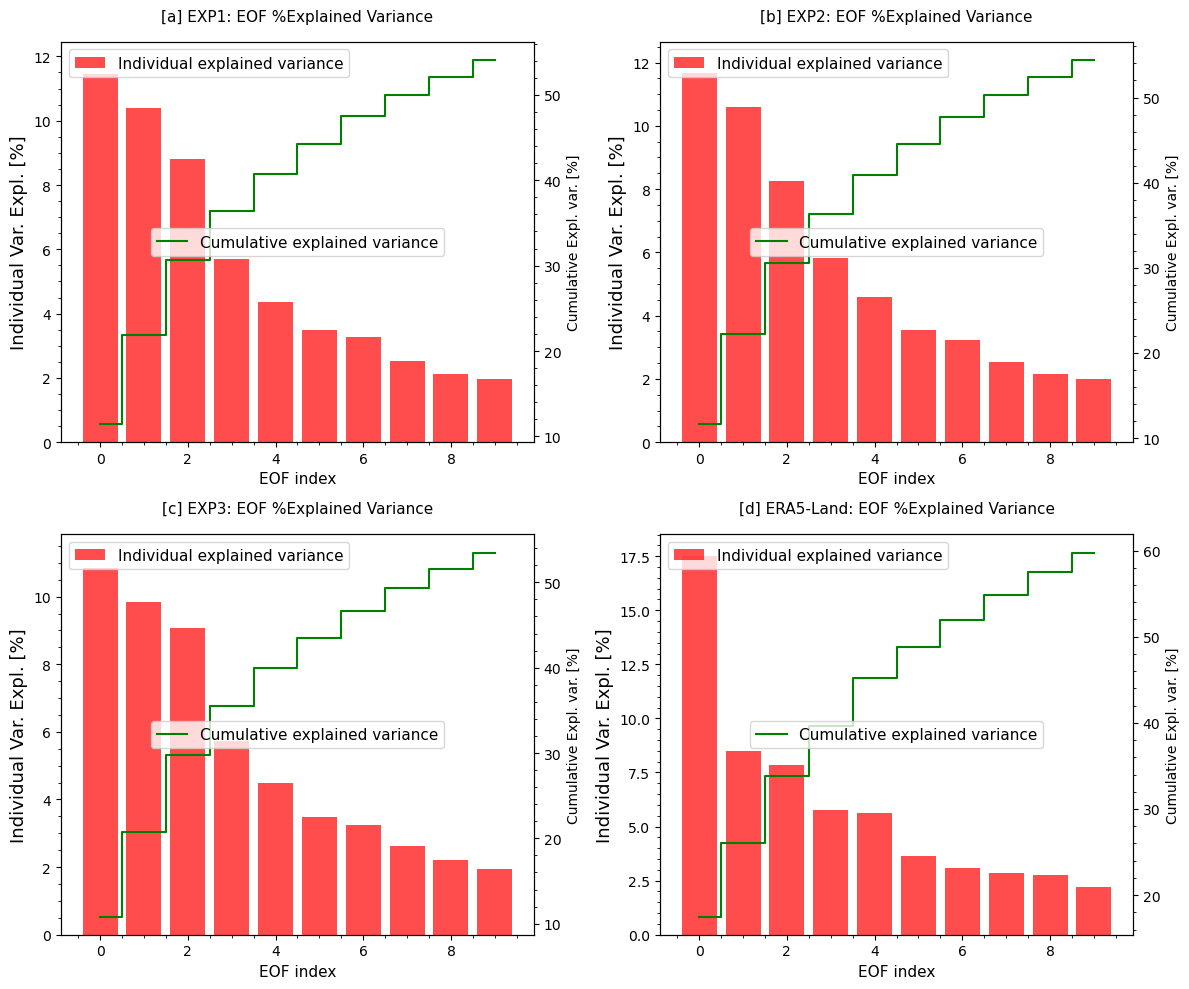

In [8]:
# =============================================================================
#                     Explained
# =============================================================================

#------------ Plot for Exp1, Exp2, Exp3, and ERA5
num_subplots = 4
var_fracs_list = [spmip_var_fracs1, spmip_var_fracs2, spmip_var_fracs3, era5_var_fracs]
title_list = [
    "[a] EXP1: EOF %Explained Variance",
    "[b] EXP2: EOF %Explained Variance",
    "[c] EXP3: EOF %Explained Variance",
    "[d] ERA5-Land: EOF %Explained Variance"
]
plot_explained_variance(num_subplots, var_fracs_list, title_list, n_modes=10)
# plt.savefig(figure+"/EXP123_Exp_var.pdf", dpi=600, bbox_inches='tight')

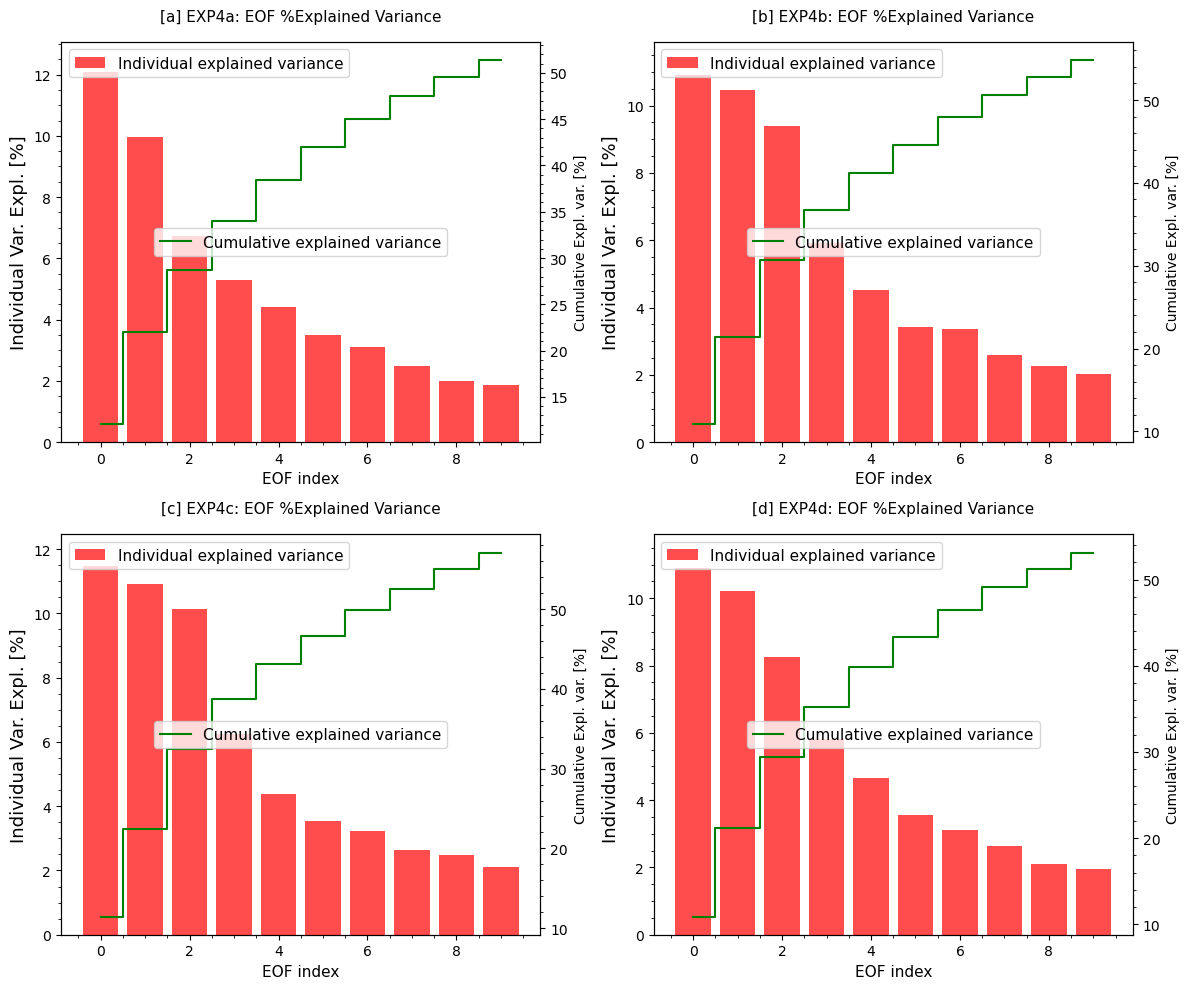

In [9]:
#------------ Plot for Exp4a, Exp4b, Exp4c, Exp4d
num_subplots = 4
var_fracs_list = [spmip_var_fracs4a, spmip_var_fracs4b, spmip_var_fracs4c, spmip_var_fracs4d]
title_list = [
    "[a] EXP4a: EOF %Explained Variance",
    "[b] EXP4b: EOF %Explained Variance",
    "[c] EXP4c: EOF %Explained Variance",
    "[d] EXP4d: EOF %Explained Variance"
]
plot_explained_variance(num_subplots, var_fracs_list, title_list, n_modes=10)
# plt.savefig(figure+"//EXP4abcd_Exp_var.pdf", dpi=600, bbox_inches='tight')

#       PLOTTING OF PC and EOF 

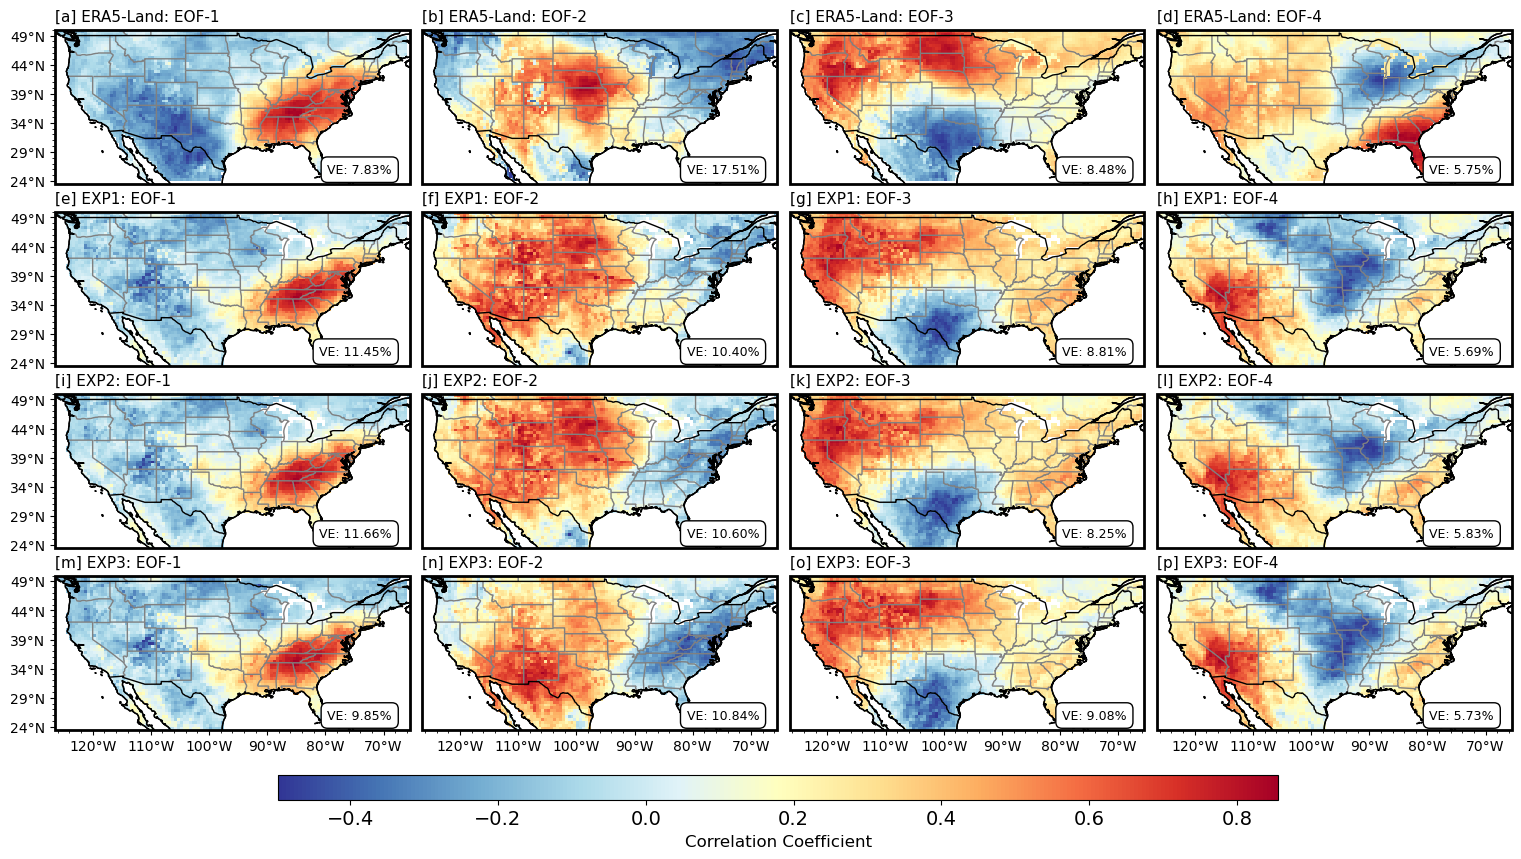

In [10]:
# =============================================================================
#       PLOTTING OF EOF FOR EXPERIMENTS 1,2,3
# =============================================================================

# --------------------------- Figure Setup --------------------------- #
fig, ax = plt.subplots(
    nrows=4, ncols=4,
    figsize=(20, 10),
    subplot_kw={'projection': ccrs.PlateCarree()},
    gridspec_kw={'wspace': -0.18, 'hspace': 0.18}
)

# Add thick black edges around each subplot
for axis in ax.flat:
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

# -------------------- ERA5 (Row 0, EOFs 1-4) -------------------- #
cs1e = contour_plot(
    -era5_eofs_corr[2, :, :], era5_var_fracs[2],
    ax=ax[0, 0],
    title='[a] ERA5-Land: EOF-1',
    is_first_subplot=True
)
cs2e = contour_plot(
    era5_eofs_corr[0, :, :], era5_var_fracs[0],
    ax=ax[0, 1],
    title='[b] ERA5-Land: EOF-2'
)
cs3e = contour_plot(
    era5_eofs_corr[1, :, :], era5_var_fracs[1],
    ax=ax[0, 2],
    title='[c] ERA5-Land: EOF-3'
)
_ = contour_plot(
    era5_eofs_corr[3, :, :], era5_var_fracs[3],
    ax=ax[0, 3],
    title='[d] ERA5-Land: EOF-4'
)

# -------------------- CLM5 Exp1 (Row 1, EOFs 1-4) -------------------- #
cs1 = contour_plot(
    spmip_eofs_corr1[0, :, :], spmip_var_fracs1[0],
    ax=ax[1, 0],
    title='[e] EXP1: EOF-1',
    is_first_subplot=True
)
cs2 = contour_plot(
    spmip_eofs_corr1[1, :, :], spmip_var_fracs1[1],
    ax=ax[1, 1],
    title='[f] EXP1: EOF-2'
)
cs3 = contour_plot(
    spmip_eofs_corr1[2, :, :], spmip_var_fracs1[2],
    ax=ax[1, 2],
    title='[g] EXP1: EOF-3'
)
_ = contour_plot(
    spmip_eofs_corr1[3, :, :], spmip_var_fracs1[3],
    ax=ax[1, 3],
    title='[h] EXP1: EOF-4'
)

# -------------------- CLM5 Exp2 (Row 2, EOFs 1-4) -------------------- #
cs4 = contour_plot(
    spmip_eofs_corr2[0, :, :], spmip_var_fracs2[0],
    ax=ax[2, 0],
    title='[i] EXP2: EOF-1',
    is_first_subplot=True
)
cs5 = contour_plot(
    spmip_eofs_corr2[1, :, :], spmip_var_fracs2[1],
    ax=ax[2, 1],
    title='[j] EXP2: EOF-2'
)
cs6 = contour_plot(
    spmip_eofs_corr2[2, :, :], spmip_var_fracs2[2],
    ax=ax[2, 2],
    title='[k] EXP2: EOF-3'
)
_ = contour_plot(
    spmip_eofs_corr2[3, :, :], spmip_var_fracs2[3],
    ax=ax[2, 3],
    title='[l] EXP2: EOF-4'
)

# -------------------- CLM5 Exp3 (Row 3, EOFs 1-4) -------------------- #
cs7 = contour_plot(
    -spmip_eofs_corr3[1, :, :], spmip_var_fracs3[1],
    ax=ax[3, 0],
    title='[m] EXP3: EOF-1',
    is_first_subplot=True,
    is_last_row=True
)
cs8 = contour_plot(
    -spmip_eofs_corr3[0, :, :], spmip_var_fracs3[0],
    ax=ax[3, 1],
    title='[n] EXP3: EOF-2',
    is_last_row=True
)
cs9 = contour_plot(
    spmip_eofs_corr3[2, :, :], spmip_var_fracs3[2],
    ax=ax[3, 2],
    title='[o] EXP3: EOF-3',
    is_last_row=True
)
_ = contour_plot(
    spmip_eofs_corr3[3, :, :], spmip_var_fracs3[3],
    ax=ax[3, 3],
    title='[p] EXP3: EOF-4',
    is_last_row=True
)

# -------------------- Single Horizontal Colorbar -------------------- #
# Adjust bottom/top margins for colorbar space
fig.subplots_adjust(bottom=0.2, top=0.9)

# Position and size of colorbar: [left, bottom, width, height]
cbar_ax = fig.add_axes([0.26, 0.13, 0.5, 0.025])
cbar = fig.colorbar(cs1, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Correlation Coefficient', fontweight='regular', fontsize=12)
# plt.savefig(figure+"/ERA5_SPMIP-EOF_EXP123.pdf", dpi=600, bbox_inches='tight')
plt.show()


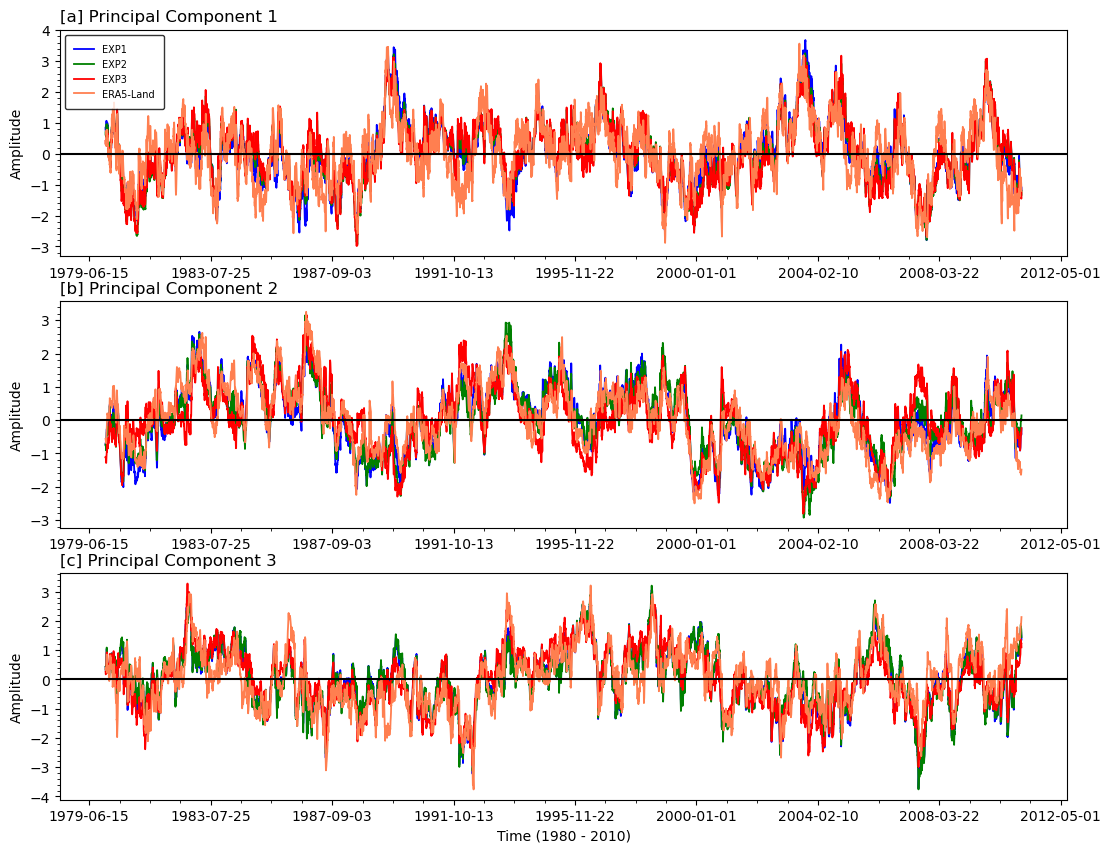

In [11]:
# =============================================================================
#       PLOTTING OF PC FOR EXPERIMENTS 1,2,3
# =============================================================================

fig, axes = plt.subplots(3, 1, figsize=(13,10), gridspec_kw={'wspace': 0.02, 'hspace': 0.2})

era5_pcs = era5_pcs[:11315]

time = data_CLM5_Exp1.time
#------------- Plot the first EOF with labels
colors = ['b', 'green', 'r',"coral","y"]
plot_eofs_over_time(axes[0], time, 
                   [spmip_pcs1[:,0], spmip_pcs2[:,0], -spmip_pcs3[:,1], -era5_pcs[:,2]],
                   ["EXP1", "EXP2", "EXP3", "ERA5-Land","Pr"],
                   "[a] Principal Component 1", "", "Amplitude",colors, x_label=True)

plot_eofs_over_time(axes[1], time, 
                   [spmip_pcs1[:,1], spmip_pcs2[:,1], -spmip_pcs3[:,0], era5_pcs[:,0]],
                   None,  # No labels for this plot
                   "[b] Principal Component 2", "", "Amplitude",colors, x_label=True)

plot_eofs_over_time(axes[2], time, 
                   [spmip_pcs1[:,2], spmip_pcs2[:,2], spmip_pcs3[:,2], era5_pcs[:,1]],
                   None,  # No labels for this plot
                   "[c] Principal Component 3", "Time (1980 - 2010)", "Amplitude",colors, x_label=True)

plt.tight_layout()
# plt.savefig(figure+"/PC_EXP123.pdf", dpi = 1000, bbox_inches='tight')
plt.show()

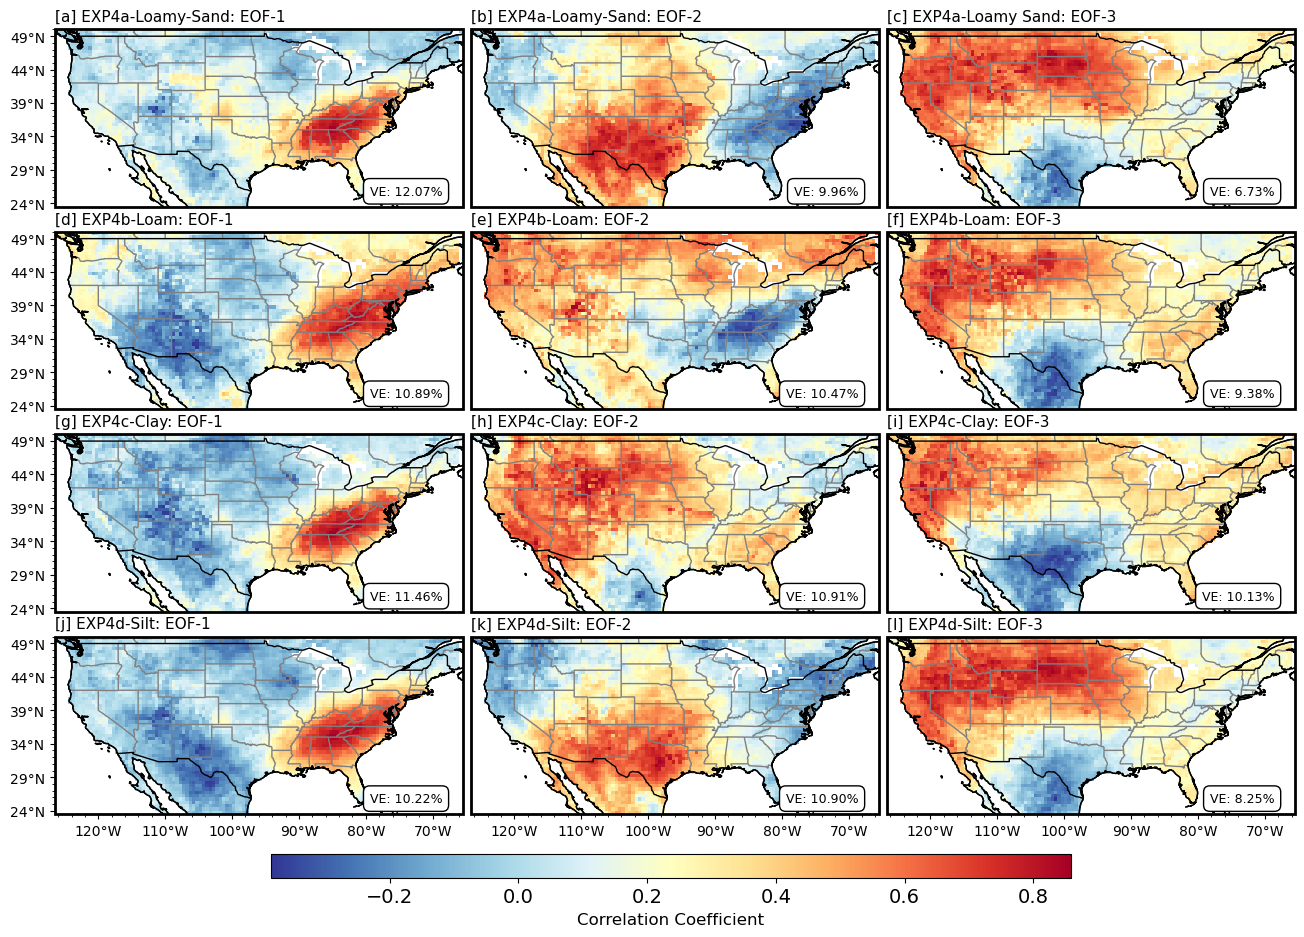

In [12]:
# =============================================================================
#       PLOTTING OF EOF MAP FOR EXPERIMENTS 4a-d
# =============================================================================

# Create a 4×3 grid of subplots with PlateCarree projection
fig, ax = plt.subplots(
    nrows=4, ncols=3,
    figsize=(16, 12),
    subplot_kw={'projection': ccrs.PlateCarree()},
    gridspec_kw={'wspace': 0.02, 'hspace': -0.13}
)

# Give each subplot a thick black border
for axis in ax.flat:
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

# ========================== EXP4a (Row 0) ==========================
cs10 = contour_plot(
    spmip_eofs_corr4a[0, :, :], spmip_var_fracs4a[0],
    ax=ax[0, 0],
    title='[a] EXP4a-Loamy-Sand: EOF-1',
    is_first_subplot=True
)
cs11 = contour_plot(
    spmip_eofs_corr4a[1, :, :], spmip_var_fracs4a[1],
    ax=ax[0, 1],
    title='[b] EXP4a-Loamy-Sand: EOF-2'
)
cs12 = contour_plot(
    -spmip_eofs_corr4a[2, :, :], spmip_var_fracs4a[2],
    ax=ax[0, 2],
    title='[c] EXP4a-Loamy Sand: EOF-3'
)

# ========================== EXP4b (Row 1) ==========================
cs13 = contour_plot(
    spmip_eofs_corr4b[0, :, :], spmip_var_fracs4b[0],
    ax=ax[1, 0],
    title='[d] EXP4b-Loam: EOF-1',
    is_first_subplot=True
)
cs14 = contour_plot(
    spmip_eofs_corr4b[1, :, :], spmip_var_fracs4b[1],
    ax=ax[1, 1],
    title='[e] EXP4b-Loam: EOF-2'
)
cs15 = contour_plot(
    spmip_eofs_corr4b[2, :, :], spmip_var_fracs4b[2],
    ax=ax[1, 2],
    title='[f] EXP4b-Loam: EOF-3'
)

# ========================== EXP4c (Row 2) ==========================
cs16 = contour_plot(
    spmip_eofs_corr4c[0, :, :], spmip_var_fracs4c[0],
    ax=ax[2, 0],
    title='[g] EXP4c-Clay: EOF-1',
    is_first_subplot=True
)
cs17 = contour_plot(
    spmip_eofs_corr4c[1, :, :], spmip_var_fracs4c[1],
    ax=ax[2, 1],
    title='[h] EXP4c-Clay: EOF-2'
)
cs18 = contour_plot(
    spmip_eofs_corr4c[2, :, :], spmip_var_fracs4c[2],
    ax=ax[2, 2],
    title='[i] EXP4c-Clay: EOF-3'
)

# ========================== EXP4d (Row 3) ==========================
cs19 = contour_plot(
    -spmip_eofs_corr4d[1, :, :], spmip_var_fracs4d[1],
    ax=ax[3, 0],
    title='[j] EXP4d-Silt: EOF-1',
    is_first_subplot=True,
    is_last_row=True
)
cs20 = contour_plot(
    -spmip_eofs_corr4d[0, :, :], spmip_var_fracs4d[0],
    ax=ax[3, 1],
    title='[k] EXP4d-Silt: EOF-2',
    is_last_row=True
)
cs21 = contour_plot(
    -spmip_eofs_corr4d[2, :, :], spmip_var_fracs4d[2],
    ax=ax[3, 2],
    title='[l] EXP4d-Silt: EOF-3',
    is_last_row=True
)

# ======================== Single Colorbar ========================= #
fig.subplots_adjust(bottom=0.2, top=0.9)
cbar_ax = fig.add_axes([0.26, 0.17, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(cs10, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Correlation Coefficient', fontweight="regular", fontsize=12)
# plt.savefig(figure+"/SPMIP-EOF_EXP4abcd.pdf", dpi=600, bbox_inches='tight')
plt.show()


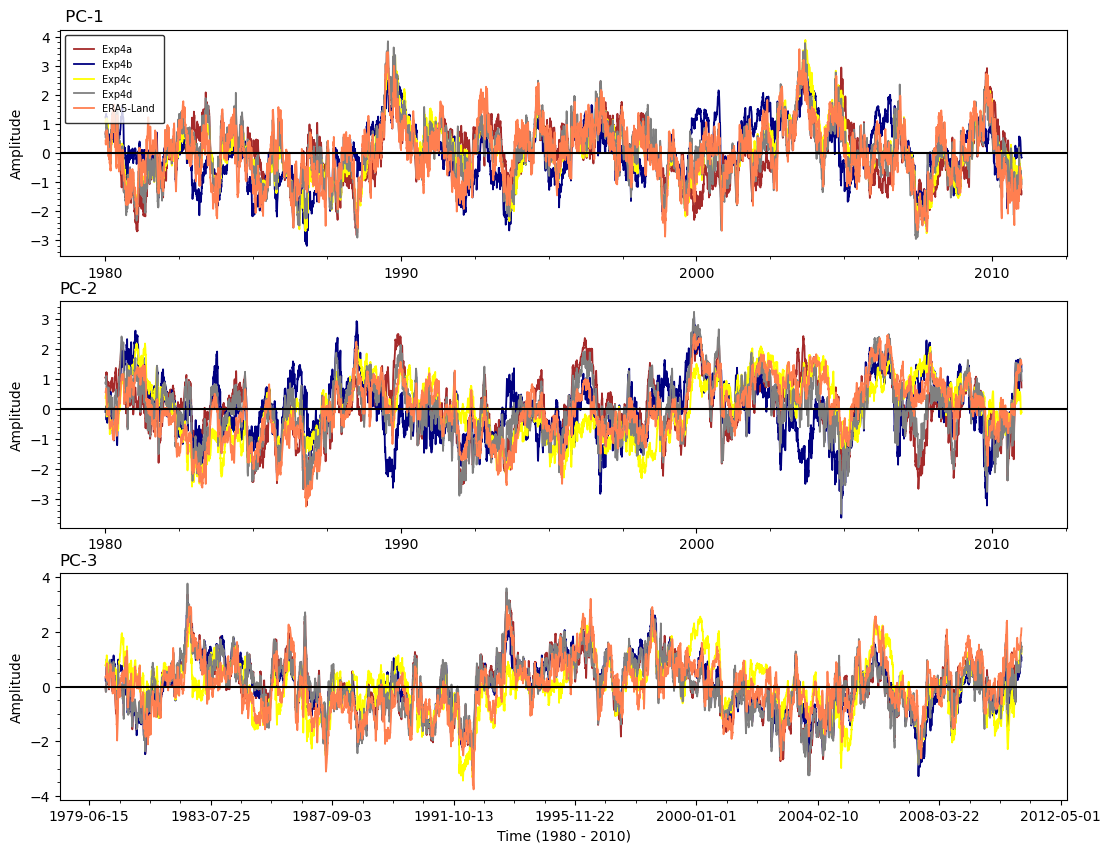

In [13]:
# =============================================================================
#       PLOTTING OF PC FOR EXPERIMENTS 4a-d
# =============================================================================

fig, axes = plt.subplots(3, 1, figsize=(13,10), gridspec_kw={'wspace': 0.02, 'hspace': 0.2})

time = data_CLM5_Exp1.time
 
colors = [ 'brown', "navy", "yellow", "grey","coral"]
plot_eofs_over_time(axes[0], time, 
                   [ spmip_pcs4a[:,0], spmip_pcs4b[:,0], spmip_pcs4c[:,0], -spmip_pcs4d[:,1],-era5_pcs[:,2]],
                   ["Exp4a", "Exp4b", "Exp4c", "Exp4d","ERA5-Land"],
                   " PC-1", "", "Amplitude",colors)

plot_eofs_over_time(axes[1], time, 
                   [-spmip_pcs4a[:,1], spmip_pcs4b[:,1], -spmip_pcs4c[:,1], spmip_pcs4d[:,0], -era5_pcs[:,0]],
                   None,  # No labels for this plot
                   "PC-2", "", "Amplitude",colors)

plot_eofs_over_time(axes[2], time, 
                   [ -spmip_pcs4a[:,2], spmip_pcs4b[:,2], spmip_pcs4c[:,2], -spmip_pcs4d[:,2], era5_pcs[:,1]],
                   None,  # No labels for this plot
                   "PC-3", "Time (1980 - 2010)", "Amplitude",colors, x_label=True)

plt.tight_layout()
# plt.savefig(figure+"/b_PC_4abcd.pdf", dpi = 1000, bbox_inches='tight')
plt.show()

# EUCLIDEAN DISTANCE 

In [14]:
# =============================================================================
#            CALCULATE POINTWISE EUCLIDEAN DISTANCES FOR EXPERIMENTS 4a-d
# =============================================================================
lat = data_CLM5_Exp1.lat
lon = data_CLM5_Exp1.lon

#================= EXP1: Compare ERA5 vs. CLM5 Exp1 =================
eof1exp1_eucd = EucDistance(-era5_eofs[2, :, :],  spmip_eofs1[0, :, :])
eof2exp1_eucd = EucDistance( era5_eofs[0, :, :],  spmip_eofs1[1, :, :])
eof3exp1_eucd = EucDistance( era5_eofs[1, :, :],  spmip_eofs1[2, :, :])
eof4exp1_eucd = EucDistance(-era5_eofs[3, :, :],  spmip_eofs1[3, :, :])

#================= EXP2: Compare ERA5 vs. CLM5 Exp2 =================
eof1exp2_eucd = EucDistance(-era5_eofs[2, :, :],  spmip_eofs2[0, :, :])
eof2exp2_eucd = EucDistance( era5_eofs[0, :, :],  spmip_eofs2[1, :, :])
eof3exp2_eucd = EucDistance( era5_eofs[1, :, :],  spmip_eofs2[2, :, :])
eof4exp2_eucd = EucDistance(-era5_eofs[3, :, :],  spmip_eofs2[3, :, :])

#================= EXP3: Compare ERA5 vs. CLM5 Exp3 =================
#  Note that some of the CLM5 Exp3 EOF indices are sign-flipped (e.g., -spmip_eofs3[1, :, :])
eof1exp3_eucd = EucDistance(-era5_eofs[2, :, :], -spmip_eofs3[1, :, :])
eof2exp3_eucd = EucDistance( era5_eofs[0, :, :], -spmip_eofs3[0, :, :])
eof3exp3_eucd = EucDistance( era5_eofs[1, :, :],  spmip_eofs3[2, :, :])
eof4exp3_eucd = EucDistance(-era5_eofs[3, :, :],  spmip_eofs3[3, :, :])

#================= EXP4a: Compare ERA5 vs. CLM5 Exp4a ================
eof1exp4a_eucd = EucDistance(-era5_eofs[2, :, :],  spmip_eofs4a[0, :, :])
eof2exp4a_eucd = EucDistance( era5_eofs[0, :, :],  spmip_eofs4a[1, :, :])
eof3exp4a_eucd = EucDistance( era5_eofs[1, :, :], -spmip_eofs4a[2, :, :])
eof4exp4a_eucd = EucDistance(-era5_eofs[3, :, :],  spmip_eofs4a[3, :, :])

#================= EXP4b: Compare ERA5 vs. CLM5 Exp4b ================
#  Note the sign-flip on the second ERA5 EOF and the first Exp4b EOF (era5_eofs[0, :, :], -spmip_eofs4b[0, :, :])
eof1exp4b_eucd = EucDistance(-era5_eofs[2, :, :],  spmip_eofs4b[0, :, :])
eof2exp4b_eucd = EucDistance( era5_eofs[0, :, :], -spmip_eofs4b[0, :, :])  
eof3exp4b_eucd = EucDistance( era5_eofs[1, :, :],  spmip_eofs4b[2, :, :])
eof4exp4b_eucd = EucDistance(-era5_eofs[3, :, :],  spmip_eofs4b[3, :, :])

#================= EXP4c: Compare ERA5 vs. CLM5 Exp4c ================
eof1exp4c_eucd = EucDistance(-era5_eofs[2, :, :],  spmip_eofs4c[0, :, :])
eof2exp4c_eucd = EucDistance( era5_eofs[0, :, :],  spmip_eofs4c[1, :, :])
eof3exp4c_eucd = EucDistance( era5_eofs[1, :, :],  spmip_eofs4c[2, :, :])
eof4exp4c_eucd = EucDistance(-era5_eofs[3, :, :],  spmip_eofs4c[3, :, :])

#================= EXP4d: Compare ERA5 vs. CLM5 Exp4d ================
eof1exp4d_eucd = EucDistance(-era5_eofs[2, :, :], -spmip_eofs4d[1, :, :])
eof2exp4d_eucd = EucDistance( era5_eofs[0, :, :], -spmip_eofs4d[0, :, :])
eof3exp4d_eucd = EucDistance( era5_eofs[1, :, :], -spmip_eofs4d[2, :, :])
eof4exp4d_eucd = EucDistance(-era5_eofs[3, :, :],  spmip_eofs4d[3, :, :])


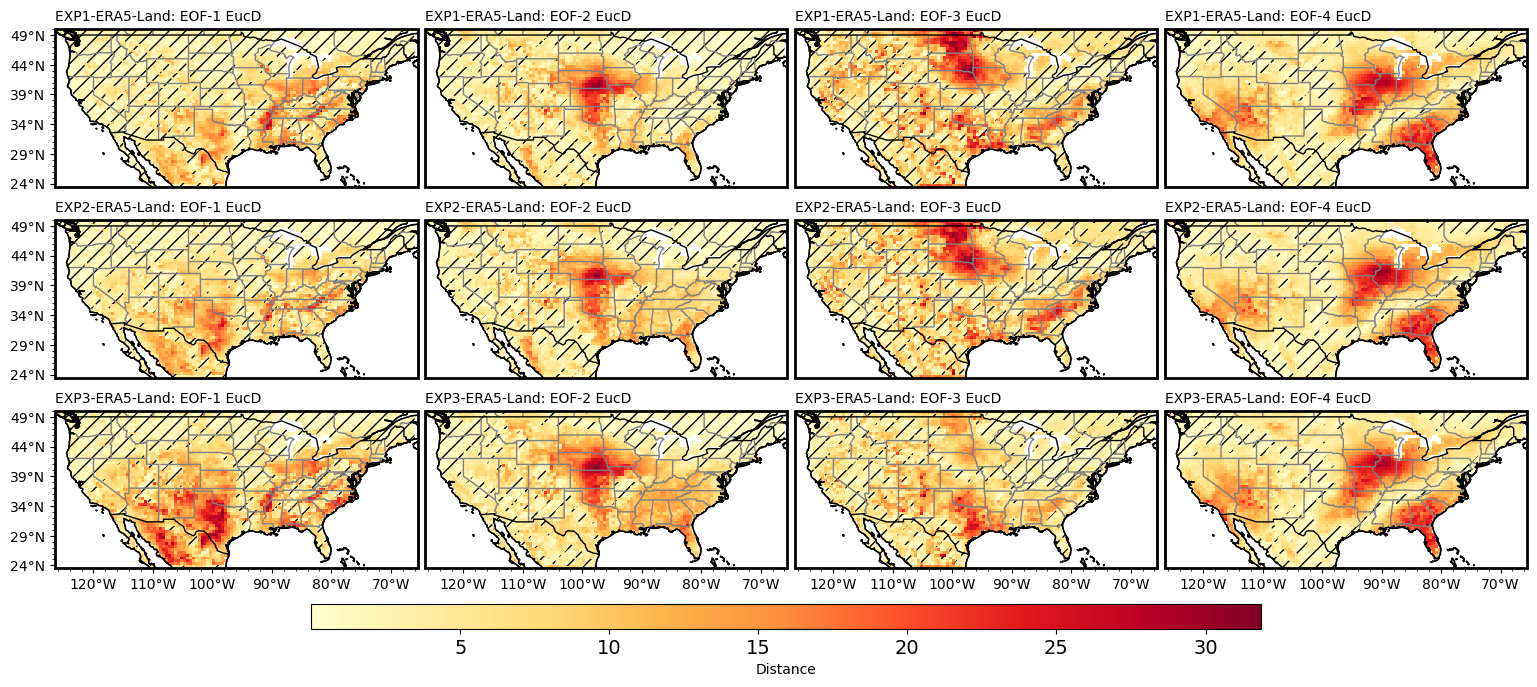

In [15]:
# =============================================================================
#       PLOTTING OF EUCLIDEAN  FOR EXPERIMENT 1,2,3
# ============================================================================

fig, ax = plt.subplots(
    nrows=3, ncols=4,
    figsize=(19, 10),
    subplot_kw={'projection': ccrs.PlateCarree()},
    gridspec_kw={'wspace': 0.02, 'hspace': -0.4}
)

# Set thick black borders for each subplot
for axis in ax.flat:
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

# Threshold for hatching
threshold = 3

# ============================= EXP 1 (Row 0) =============================
mesh_1e1 = plot_map_with_threshold(
    ax=ax[0, 0],
    distance=eof1exp1_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="EXP1-ERA5-Land: EOF-1 EucD",
    is_first_subplot=True
)
mesh_1e2 = plot_map_with_threshold(
    ax=ax[0, 1],
    distance=eof2exp1_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="EXP1-ERA5-Land: EOF-2 EucD"
)
mesh_1e3 = plot_map_with_threshold(
    ax=ax[0, 2],
    distance=eof3exp1_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="EXP1-ERA5-Land: EOF-3 EucD"
)
mesh_1e4 = plot_map_with_threshold(
    ax=ax[0, 3],
    distance=eof4exp1_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="EXP1-ERA5-Land: EOF-4 EucD"
)

# ============================= EXP 2 (Row 1) =============================
mesh_2e1 = plot_map_with_threshold(
    ax=ax[1, 0],
    distance=eof1exp2_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="EXP2-ERA5-Land: EOF-1 EucD",
    is_first_subplot=True
)
mesh_2e2 = plot_map_with_threshold(
    ax=ax[1, 1],
    distance=eof2exp2_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="EXP2-ERA5-Land: EOF-2 EucD"
)
mesh_2e3 = plot_map_with_threshold(
    ax=ax[1, 2],
    distance=eof3exp2_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="EXP2-ERA5-Land: EOF-3 EucD"
)
mesh_2e4 = plot_map_with_threshold(
    ax=ax[1, 3],
    distance=eof4exp2_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="EXP2-ERA5-Land: EOF-4 EucD"
)

# ============================= EXP 3 (Row 2) =============================
mesh_3e1 = plot_map_with_threshold(
    ax=ax[2, 0],
    distance=eof1exp3_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="EXP3-ERA5-Land: EOF-1 EucD",
    is_first_subplot=True,
    is_last_row=True
)
mesh_3e2 = plot_map_with_threshold(
    ax=ax[2, 1],
    distance=eof2exp3_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="EXP3-ERA5-Land: EOF-2 EucD",
    is_last_row=True
)
mesh_3e3 = plot_map_with_threshold(
    ax=ax[2, 2],
    distance=eof3exp3_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="EXP3-ERA5-Land: EOF-3 EucD",
    is_last_row=True
)
mesh_3e4 = plot_map_with_threshold(
    ax=ax[2, 3],
    distance=eof4exp3_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="EXP3-ERA5-Land: EOF-4 EucD",
    is_last_row=True
)

# =========================== Figure Layout & Colorbar =========================
fig.subplots_adjust(bottom=0.2, top=0.9)
cbar_ax = fig.add_axes([0.26, 0.22, 0.5, 0.025])  # [left, bottom, width, height]
cbar = fig.colorbar(mesh_2e2, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Distance', fontweight='regular', fontsize=10)
# Save figure to file
# plt.savefig(figure+"/EOF_EucD_Exp123.pdf", dpi=600, bbox_inches='tight')
plt.show()

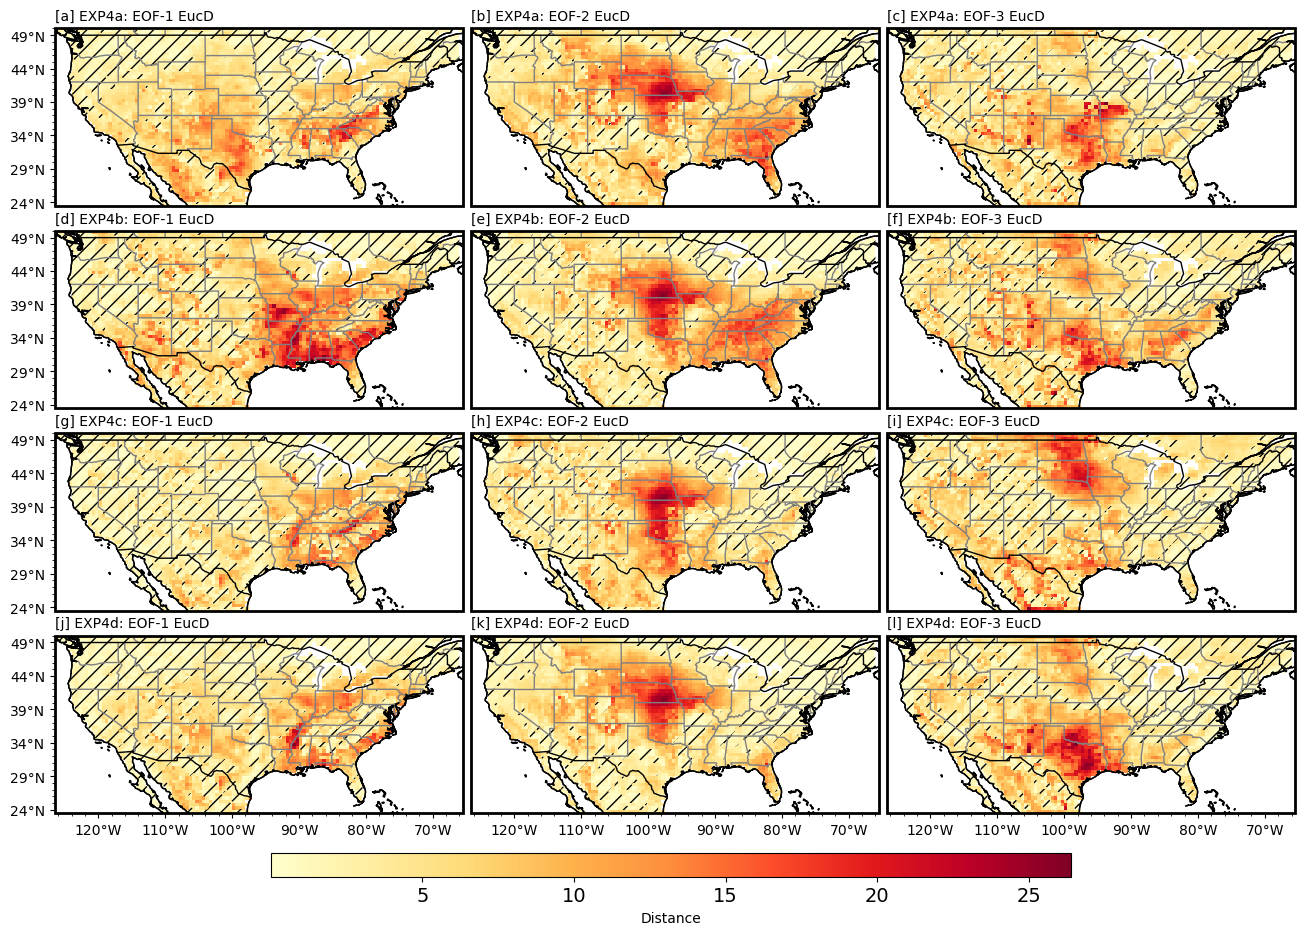

In [16]:
# =============================================================================
#       PLOTTING OF EUCLIDEAN  FOR EXPERIMENT 4a-d
# ============================================================================

#------------- Create a 4×3 grid of subplots, each using a PlateCarree map projection
fig, ax = plt.subplots(
    nrows=4, ncols=3, 
    figsize=(16, 12),
    subplot_kw={'projection': ccrs.PlateCarree()},
    gridspec_kw={'wspace': 0.02, 'hspace': -0.13}
)

#------------- Set thick black borders around each subplot
for axis in ax.flat:
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

#------------- Threshold for hatching
threshold = 3

# ----------------------------- Row 1: EXP4a ----------------------------- #
cs_4ae1 = plot_map_with_threshold(
    ax=ax[0, 0],
    distance=eof1exp4a_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="[a] EXP4a: EOF-1 EucD",
    is_first_subplot=True
)
cs_4ae2 = plot_map_with_threshold(
    ax=ax[0, 1],
    distance=eof2exp4a_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="[b] EXP4a: EOF-2 EucD"
)
cs_4ae3 = plot_map_with_threshold(
    ax=ax[0, 2],
    distance=eof3exp4a_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="[c] EXP4a: EOF-3 EucD"
)

# ----------------------------- Row 2: EXP4b ----------------------------- #
cs_4be1 = plot_map_with_threshold(
    ax=ax[1, 0],
    distance=eof1exp4b_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="[d] EXP4b: EOF-1 EucD",
    is_first_subplot=True
)
cs_4be2 = plot_map_with_threshold(
    ax=ax[1, 1],
    distance=eof2exp4b_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="[e] EXP4b: EOF-2 EucD"
)
cs_4be3 = plot_map_with_threshold(
    ax=ax[1, 2],
    distance=eof3exp4b_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="[f] EXP4b: EOF-3 EucD"
)

# ----------------------------- Row 3: EXP4c ----------------------------- #
cs_4ce1 = plot_map_with_threshold(
    ax=ax[2, 0],
    distance=eof1exp4c_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="[g] EXP4c: EOF-1 EucD",
    is_first_subplot=True
)
cs_4ce2 = plot_map_with_threshold(
    ax=ax[2, 1],
    distance=eof2exp4c_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="[h] EXP4c: EOF-2 EucD"
)
cs_4ce3 = plot_map_with_threshold(
    ax=ax[2, 2],
    distance=eof3exp4c_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="[i] EXP4c: EOF-3 EucD"
)

# ----------------------------- Row 4: EXP4d ----------------------------- #
cs_4de1 = plot_map_with_threshold(
    ax=ax[3, 0],
    distance=eof1exp4d_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="[j] EXP4d: EOF-1 EucD",
    is_first_subplot=True,
    is_last_row=True
)
cs_4de2 = plot_map_with_threshold(
    ax=ax[3, 1],
    distance=eof2exp4d_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="[k] EXP4d: EOF-2 EucD",
    is_last_row=True
)
cs_4de3 = plot_map_with_threshold(
    ax=ax[3, 2],
    distance=eof3exp4d_eucd,
    threshold=threshold,
    mask=mask,
    lon=lon,
    lat=lat,
    title="[l] EXP4d: EOF-3 EucD",
    is_last_row=True
)

# ========================= Colorbar and Layout ========================= #
fig.subplots_adjust(bottom=0.2, top=0.9)
cbar_ax = fig.add_axes([0.26, 0.17, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(cs_4ae1, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Distance', fontweight='regular', fontsize=10)
# plt.savefig(figure+"/EOF_EucD_Exp4abcd.pdf", dpi=600, bbox_inches='tight')
plt.show()


# Taylor Diagram 

In [17]:
#=============================================================
# 1) EOF-1: Standard Deviation (Reference) + Model Comparisons
#=============================================================
stdref_eof1 = era5_eofs[2, :, :].std(ddof=1).values

EOF1 = [
    [
        spmip_eofs1[0, :, :].std(ddof=1),
        corrcoef(-era5_eofs[2, :, :], spmip_eofs1[0, :, :]),
        "EXP1"
    ],
    [
        spmip_eofs2[0, :, :].std(ddof=1),
        corrcoef(-era5_eofs[2, :, :], spmip_eofs2[0, :, :]),
        "EXP2"
    ],
    [
        spmip_eofs3[1, :, :].std(ddof=1),
        corrcoef(-era5_eofs[2, :, :], -spmip_eofs3[1, :, :]),
        "EXP3"
    ],
    [
        spmip_eofs4a[0, :, :].std(ddof=1),
        corrcoef(-era5_eofs[2, :, :], spmip_eofs4a[0, :, :]),
        "EXP4a"
    ],
    [
        spmip_eofs4b[0, :, :].std(ddof=1),
        corrcoef(-era5_eofs[2, :, :], spmip_eofs4b[0, :, :]),
        "EXP4b"
    ],
    [
        spmip_eofs4c[0, :, :].std(ddof=1),
        corrcoef(-era5_eofs[2, :, :], spmip_eofs4c[0, :, :]),
        "EXP4c"
    ],
    [
        spmip_eofs4d[1, :, :].std(ddof=1),
        corrcoef(-era5_eofs[2, :, :], -spmip_eofs4d[1, :, :]),
        "EXP4d"
    ],
]


#=============================================================
# 2) EOF-2: Standard Deviation (Reference) + Model Comparisons
#=============================================================
stdref_eof2 = era5_eofs[0, :, :].std(ddof=1).values

EOF2 = [
    [
        spmip_eofs1[1, :, :].std(ddof=1),
        corrcoef(era5_eofs[0, :, :], spmip_eofs1[1, :, :]),
        "EXP1"
    ],
    [
        spmip_eofs2[1, :, :].std(ddof=1),
        corrcoef(era5_eofs[0, :, :], spmip_eofs2[1, :, :]),
        "EXP2"
    ],
    [
        spmip_eofs3[0, :, :].std(ddof=1),
        corrcoef(era5_eofs[0, :, :], -spmip_eofs3[0, :, :]),
        "EXP3"
    ],
    [
        spmip_eofs4a[1, :, :].std(ddof=1),
        corrcoef(era5_eofs[0, :, :], spmip_eofs4a[1, :, :]),
        "EXP4a"
    ],
    [
        spmip_eofs4b[1, :, :].std(ddof=1),
        corrcoef(era5_eofs[0, :, :], -spmip_eofs4b[0, :, :]),
        "EXP4b"
    ],
    [
        spmip_eofs4c[1, :, :].std(ddof=1),
        corrcoef(era5_eofs[0, :, :], spmip_eofs4c[1, :, :]),
        "EXP4c"
    ],
    [
        spmip_eofs4d[0, :, :].std(ddof=1),
        corrcoef(era5_eofs[0, :, :], -spmip_eofs4d[0, :, :]),
        "EXP4d"
    ],
]


#=============================================================
# 3) EOF-3: Standard Deviation (Reference) + Model Comparisons
#=============================================================
stdref_eof3 = era5_eofs[1, :, :].std(ddof=1).values

EOF3 = [
    [
        spmip_eofs1[2, :, :].std(ddof=1),
        corrcoef(era5_eofs[1, :, :], spmip_eofs1[2, :, :]),
        "EXP1"
    ],
    [
        spmip_eofs2[2, :, :].std(ddof=1),
        corrcoef(era5_eofs[1, :, :], spmip_eofs2[2, :, :]),
        "EXP2"
    ],
    [
        spmip_eofs3[2, :, :].std(ddof=1),
        corrcoef(era5_eofs[1, :, :], spmip_eofs3[2, :, :]),
        "EXP3"
    ],
    [
        spmip_eofs4a[2, :, :].std(ddof=1),
        corrcoef(era5_eofs[1, :, :], -spmip_eofs4a[2, :, :]),
        "EXP4a"
    ],
    [
        spmip_eofs4b[2, :, :].std(ddof=1),
        corrcoef(era5_eofs[1, :, :], spmip_eofs4b[2, :, :]),
        "EXP4b"
    ],
    [
        spmip_eofs4c[2, :, :].std(ddof=1),
        corrcoef(era5_eofs[1, :, :], spmip_eofs4c[2, :, :]),
        "EXP4c"
    ],
    [
        spmip_eofs4d[2, :, :].std(ddof=1),
        corrcoef(era5_eofs[1, :, :], -spmip_eofs4d[2, :, :]),
        "EXP4d"
    ],
]


#=============================================================
# 4) EOF-4: Standard Deviation (Reference) + Model Comparisons
#=============================================================
stdref_eof4 = era5_eofs[3, :, :].std(ddof=1).values

EOF4 = [
    [
        spmip_eofs1[3, :, :].std(ddof=1),
        corrcoef(era5_eofs[3, :, :], spmip_eofs1[3, :, :]),
        "EXP1"
    ],
    [
        spmip_eofs2[3, :, :].std(ddof=1),
        corrcoef(era5_eofs[3, :, :], spmip_eofs2[3, :, :]),
        "EXP2"
    ],
    [
        spmip_eofs3[3, :, :].std(ddof=1),
        corrcoef(era5_eofs[3, :, :], spmip_eofs3[3, :, :]),
        "EXP3"
    ],
    [
        spmip_eofs4a[3, :, :].std(ddof=1),
        corrcoef(era5_eofs[3, :, :], spmip_eofs4a[3, :, :]),
        "EXP4a"
    ],
    [
        spmip_eofs4b[3, :, :].std(ddof=1),
        corrcoef(era5_eofs[3, :, :], spmip_eofs4b[3, :, :]),
        "EXP4b"
    ],
    [
        spmip_eofs4c[3, :, :].std(ddof=1),
        corrcoef(era5_eofs[3, :, :], spmip_eofs4c[3, :, :]),
        "EXP4c"
    ],
    [
        spmip_eofs4d[3, :, :].std(ddof=1),
        corrcoef(era5_eofs[3, :, :], spmip_eofs4d[3, :, :]),
        "EXP4d"
    ],
]


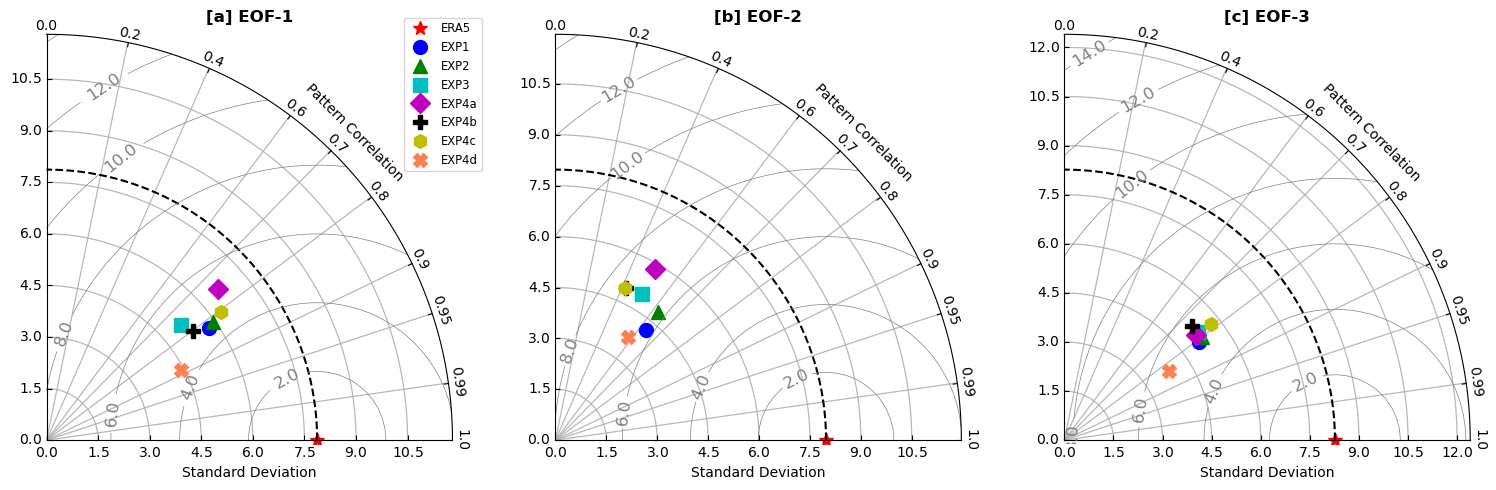

In [18]:
# =============================== PLOT =============================== #
fig = plt.figure(figsize=(15, 5))
create_taylor_diagram(stdref_eof1, EOF1, "[a] EOF-1", fig, 131, add_legend=True)
create_taylor_diagram(stdref_eof2, EOF2, "[b] EOF-2", fig, 132)
create_taylor_diagram(stdref_eof3, EOF3, "[c] EOF-3", fig, 133)
plt.savefig(figure+"/TDA123.pdf", dpi=600, bbox_inches='tight')
plt.show()


NameError: name 'PLT' is not defined

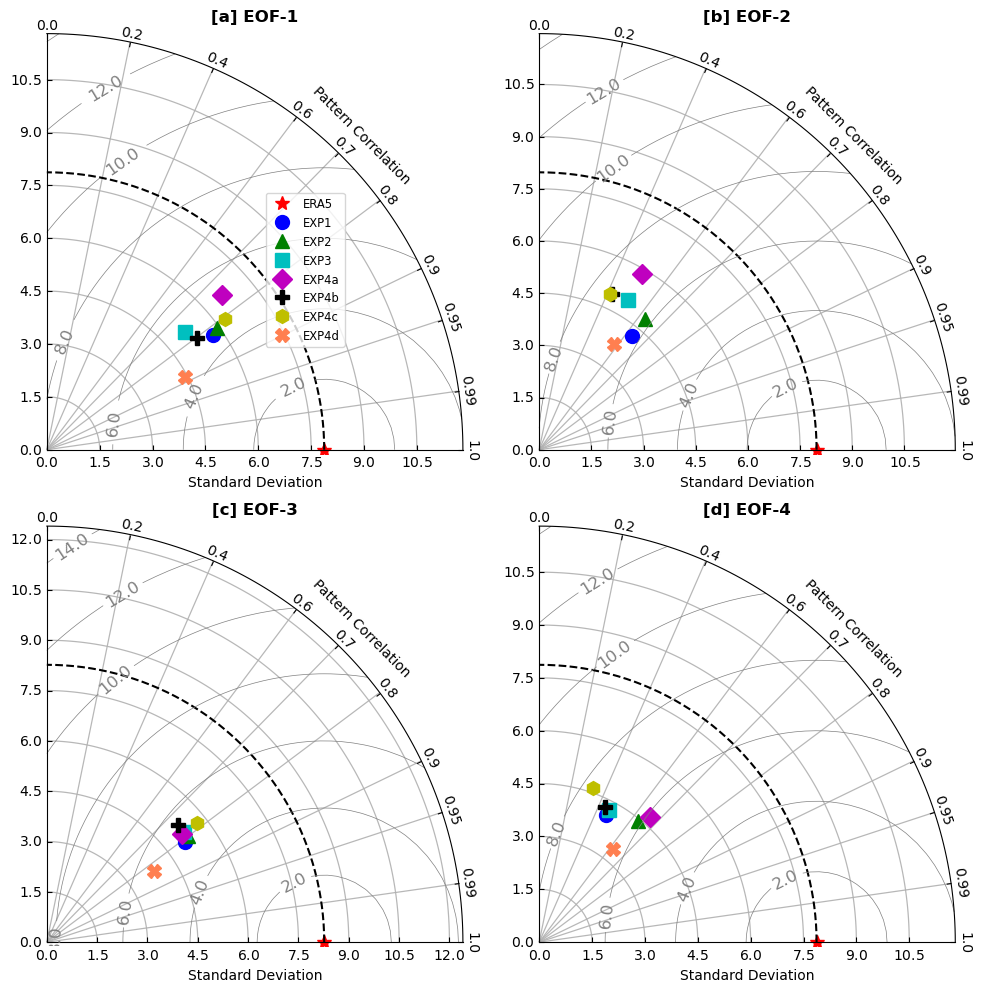

In [19]:
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
create_taylor_diagram(stdref_eof1, EOF1, "[a] EOF-1", fig, 221, add_legend=True)  # 1st subplot
create_taylor_diagram(stdref_eof2, EOF2, "[b] EOF-2", fig, 222)  # 2nd subplot
create_taylor_diagram(stdref_eof3, EOF3, "[c] EOF-3", fig, 223)  # 3rd subplot
create_taylor_diagram(stdref_eof1, EOF4, "[d] EOF-4", fig, 224)  # 3rd subplot
fig.tight_layout()
# PLT.savefig(figure+"/TaylorDiagram.pdf", dpi = 600, bbox_inches='tight')
PLT.show()
